# 2024_가을학기_실전기계학습_Competition Guide Code

1. Pretraioned Model 사용금지
2. Personal Data 사용금지
3. Epoch 50회까지 제한
4. Test Data로 Train 금지
5. Model Param 5M이상 금지
6. 최종 제출 모델 파일로 조교가 재현시 비슷한 성능이 나오지 않은 경우
Cheating으로 간주
7. Model Compression 기법 금지(수업시간에 배운 것만 이용)
8. 기타 궁금한 사항들(간단하거나 쉬운 것도 괜찮습니다)은 조교에게 질문주셔요
- Email (jrespect.im@khu.ac.kr)
- 전자정보대학 350 방문

0. 필요한 모듈을 Import 합니다.

In [ ]:
# importing all the libraries we need
import numpy as np
import sys
import matplotlib.pyplot as plt
import os
import time
import random
import pandas as pd
import seaborn as sns
from random import shuffle
import copy
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

import torch
from torch import nn, cuda, optim
from torchvision import models,transforms,datasets
from torch.utils.data import DataLoader,random_split
# torch: PyTorch의 기본 모듈로, 텐서 연산, 신경망 구현, GPU 지원 등을 제공합니다.
# nn: PyTorch의 신경망 관련 모듈로, 모델 레이어와 구조를 정의하는 데 사용됩니다.
# cuda: PyTorch의 GPU 관련 모듈로, CUDA를 사용해 연산을 가속화합니다.
# optim: PyTorch의 최적화 모듈로, SGD, Adam 등 최적화 알고리즘을 제공합니다.
# models: torchvision에서 제공하는 사전 학습된 모델과 신경망 구조를 불러옵니다.
# transforms: 이미지 전처리(크기 조정, 정규화 등)를 위한 유틸리티를 제공합니다.
# datasets: 표준 데이터셋(CIFAR, ImageNet 등)을 로드하기 위한 모듈입니다.
# DataLoader: 데이터셋을 배치 단위로 나누고 셔플 및 다중 스레드 로딩을 지원합니다.
# random_split: 데이터셋을 학습/검증/테스트 세트로 랜덤 분할하는 데 사용됩니다.

from PIL import Image
import h5py
from tensorflow.keras import utils
from __future__ import print_function, division
from torch.optim import lr_scheduler
import torch.nn.functional as F
# PIL.Image: Python Imaging Library로, 이미지 파일을 열고 처리하는 데 사용됩니다.
# h5py: HDF5 형식으로 데이터를 읽고 쓰는 데 사용됩니다. 딥러닝 모델의 가중치 저장/로드에 활용될 수 있습니다.
# tensorflow.keras.utils: TensorFlow의 Keras 유틸리티 모듈로, one-hot 인코딩 등 다양한 기능을 제공합니다.
# __future__.print_function, division: Python 2와 3의 호환성을 위해 사용됩니다. (Python 3에서는 필요하지 않음)
# torch.optim.lr_scheduler: 학습률 스케줄링을 위한 모듈로, 학습률을 점진적으로 조정합니다.
# torch.nn.functional: PyTorch의 함수형 API로, 비선형 활성화 함수(ReLU, softmax 등)를 제공합니다.


seed = 3334
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)
# torch.manual_seed(seed): PyTorch의 CPU 연산에 난수 시드를 설정합니다.
# torch.cuda.manual_seed(seed): GPU 연산에 난수 시드를 설정합니다.
# torch.cuda.manual_seed_all(seed): 멀티 GPU 환경에서 난수 시드를 설정합니다.
# torch.backends.cudnn.deterministic = True: 연산 결과를 결정적으로 만듭니다(CUDNN 사용 시).
# torch.backends.cudnn.benchmark = False: 입력 크기가 고정된 경우 최적화된 CUDNN 알고리즘 사용을 비활성화합니다.
# np.random.seed(seed): NumPy에서 난수 시드를 설정합니다.
# random.seed(seed): Python의 기본 난수 생성기에 난수 시드를 설정합니다.


1. Dataset 다운로드 및 구축

1-1.Galaxy10 dataset을 다운로드합니다.

In [ ]:
!wget https://zenodo.org/records/10845026/files/Galaxy10_DECals.h5

--2024-11-26 07:48:56--  https://zenodo.org/records/10845026/files/Galaxy10_DECals.h5
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2735267419 (2.5G) [application/octet-stream]
Saving to: ‘Galaxy10_DECals.h5’

Galaxy10_DECals.h5  100%[===================>]   2.55G  1.38MB/s    in 34m 17s 

2024-11-26 08:23:13 (1.27 MB/s) - ‘Galaxy10_DECals.h5’ saved [2735267419/2735267419]



1-2. 다운로드 받은 데이터 셋은 h5py형태이기때문에, 보통 사용하는 이미지와 라벨형태로 전환합니다.

In [ ]:
with h5py.File('/content/Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images']) # Select only few examples [0:5000]
    labels = np.array(F['ans'])

print('Data loaded successfully')

class_names = ['Disturbed', 'Merging', 'Round_Smooth',
               'In-between_Round_Smooth', 'Cigar_Shaped_Smooth', 'Barred_Spiral',
               'Unbarred_Tight_Spiral', 'Unbarred_Loose_Spiral', 'Edge-on_without_Bulge',
               'Edge-on_with_Bulge']

Data loaded successfully


1-3. 다운로드 받은 데이터 셋이 정상적인 이미지를 로드하는지 테스트해봅니다.

Images index to display: [10719 14216  5916  9672  8308]


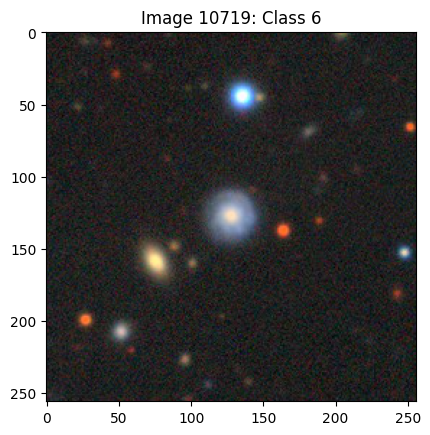

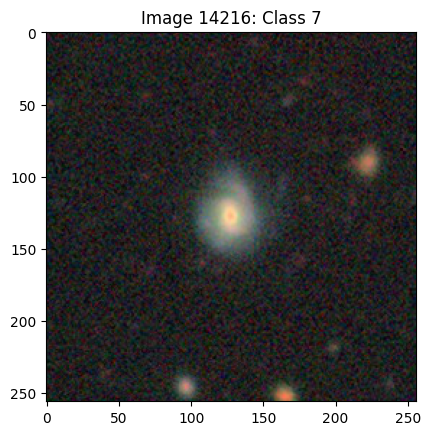

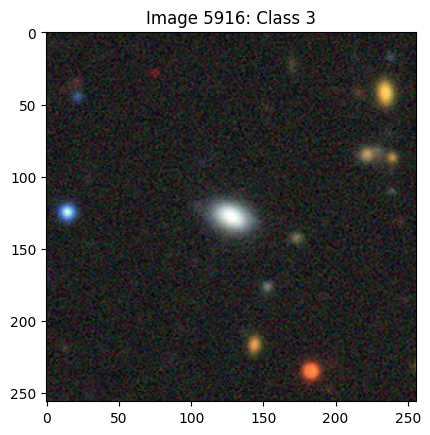

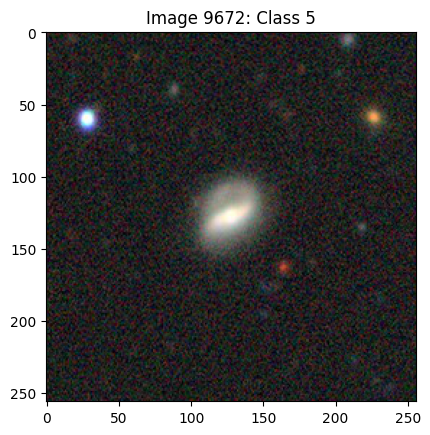

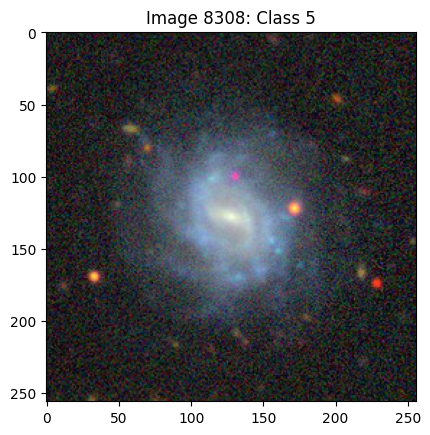

In [ ]:
img = None
plt.ion() # 설명: Matplotlib의 인터랙티브 모드를 활성화합니다. 이를 통해 그래프를 업데이트하거나 동적으로 표시할 수 있습니다.

samples = np.random.randint(0, labels.shape[0], size=5)
print('Images index to display:', samples)
for i in samples:
    img = plt.imshow(images[i])
    plt.title('Image {}: Class {}'.format(i, labels[i]))
    plt.draw() # 설명: Matplotlib에 현재 플롯(그래프)을 그리도록 명령합니다. 인터랙티브 모드에서 화면을 업데이트합니다.
    plt.pause(2.) # 설명: 2초 동안 일시 정지하여 사용자가 이미지를 확인할 수 있는 시간을 제공합니다. 이후 다음 이미지를 표시합니다.
plt.close('all')
# 설명: 모든 Matplotlib 창을 닫아 이전에 생성된 시각화 창을 정리합니다. 프로그램 종료 시 리소스를 해제하는 역할을 합니다.

1-4. 라벨 데이터를 카테고리화하여 class label로 사용하고자 만듭니다.

In [ ]:
labels_cat = utils.to_categorical(labels, 10)
print('Categorical label:', labels_cat[0])
print('Shape of data structure labels {} and images {}'.format(labels_cat.shape, images.shape))
print('Dataset images per class:', np.sum(labels_cat, axis=0))

Categorical label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Shape of data structure labels (17736, 10) and images (17736, 256, 256, 3)
Dataset images per class: [1081. 1853. 2645. 2027.  334. 2043. 1829. 2628. 1423. 1873.]


1-5. Dataset을 Train / Val+test set으로 나눕니다.


Train 70%


Valdation + Test 30%

In [ ]:
# torch.manual_seed(seed)
# if cuda:
#     torch.cuda.manual_seed(seed)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state = 3444)
for train_idx, valt_idx in sss.split(labels, labels):
    train_labels = labels_cat[train_idx]
    valt_labels = labels_cat[valt_idx]
    print("TRAIN indexes:", train_idx, "number of objects:", train_idx.shape)
    print(np.sum(train_labels, axis=0))
    print("Valtest indexes:", valt_idx, "number of objects:", valt_idx.shape)
    print(np.sum(valt_labels, axis=0))

train_labels = labels[train_idx]
valt_labels = labels[valt_idx]
train_images = images[train_idx]
valt_images = images[valt_idx]

TRAIN indexes: [ 7698  9802 15697 ...  9247 16150 12370] number of objects: (12415,)
[ 757. 1297. 1851. 1419.  234. 1430. 1280. 1840.  996. 1311.]
Valtest indexes: [16728 17541  4018 ...  1772  9998 16016] number of objects: (5321,)
[324. 556. 794. 608. 100. 613. 549. 788. 427. 562.]


In [ ]:
valtest_labels_cat = utils.to_categorical(valt_labels, 10)
print('Categorical label:', valtest_labels_cat[0])
print('Shape of data structure labels {} and images {}'.format(valtest_labels_cat.shape, valt_images.shape))
print('Dataset images per class:', np.sum(valtest_labels_cat, axis=0))

Categorical label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Shape of data structure labels (5321, 10) and images (5321, 256, 256, 3)
Dataset images per class: [324. 556. 794. 608. 100. 613. 549. 788. 427. 562.]


1-6. Val+test dataset을 Validation / Test로 나눕니다.

Validation 50%(전체의 15%)

Test 50%(전체의 15%)

In [ ]:
ssss = StratifiedShuffleSplit(n_splits=1, test_size = 0.5, random_state = 3444)
for val_idx, test_idx in ssss.split(valt_labels, valt_labels):
    val_labels = valtest_labels_cat[val_idx]
    test_labels = valtest_labels_cat[test_idx]
    print("Validation indexes:", val_idx, "number of objects:", val_idx.shape)
    print(np.sum(val_labels, axis=0))
    print("TEST indexes:", test_idx, "number of objects:", test_idx.shape)
    print(np.sum(test_labels, axis=0))

val_labels = valt_labels[val_idx]
test_labels = valt_labels[test_idx]
val_images = valt_images[val_idx]
test_images = valt_images[test_idx]

Validation indexes: [3253 1157 2996 ... 3893 3086    7] number of objects: (2660,)
[162. 278. 397. 304.  50. 306. 274. 394. 214. 281.]
TEST indexes: [ 390 2815 3137 ... 4590 2888 4915] number of objects: (2661,)
[162. 278. 397. 304.  50. 307. 275. 394. 213. 281.]


1-7. 위에서 만든 데이터 구분을 가지고 실제 dataset을 경로상으로 저장합니다.

In [ ]:
main = os.getcwd()

# 1.Create directory tree and save images
dataset_dirname = 'Galaxy10'
try:
    os.mkdir(dataset_dirname)
except OSError:
    print('OSError: Creating or already exists the directory')
# Main dataset folder
os.chdir(dataset_dirname)

# 2.Train partition
os.mkdir('train')
os.chdir('train')
for cls in class_names:   # for each class 'cls'
    os.mkdir(cls)
    # train/<class> folder save images
    cls_int = class_names.index(cls)
    print('Train - Class: ', cls)
    for i in range(len(train_labels)):   # traverse all train lavels
        if train_labels[i] == cls_int:   # save instance 'i' belong to class 'cls'
            img_path = os.path.join(os.getcwd(), cls)
            #print('Save image {} in {}'.format(i, img_path))
            img = Image.fromarray(train_images[i])
            img.save(os.path.join(img_path, 'galaxy10_img{}.jpg'.format(i)))

# 3.Validation partition
os.chdir(os.path.join(main, dataset_dirname))
os.mkdir('val')
os.chdir('val')
for cls in class_names:
    os.mkdir(cls)
    # val/<class> folder save images
    cls_int = class_names.index(cls)
    print('Validation - Class: ', cls)
    for i in range(len(val_labels)):   # traverse all train lavels
        if val_labels[i] == cls_int:   # save instance 'i' belong to class 'cls'
            img_path = os.path.join(os.getcwd(), cls)
            #print('Save image {} in {}'.format(i, img_path))
            img = Image.fromarray(val_images[i])
            img.save(os.path.join(img_path, 'galaxy10_img{}.jpg'.format(i)))

# 3.test partition
os.chdir(os.path.join(main, dataset_dirname))
os.mkdir('test')
os.chdir('test')
for cls in class_names:
    os.mkdir(cls)
    # val/<class> folder save images
    cls_int = class_names.index(cls)
    print('Test - Class: ', cls)
    for i in range(len(test_labels)):   # traverse all train lavels
        if test_labels[i] == cls_int:   # save instance 'i' belong to class 'cls'
            img_path = os.path.join(os.getcwd(), cls)
            #print('Save image {} in {}'.format(i, img_path))
            img = Image.fromarray(test_images[i])
            img.save(os.path.join(img_path, 'galaxy10_img{}.jpg'.format(i)))

os.chdir(main)

Train - Class:  Disturbed
Train - Class:  Merging
Train - Class:  Round_Smooth
Train - Class:  In-between_Round_Smooth
Train - Class:  Cigar_Shaped_Smooth
Train - Class:  Barred_Spiral
Train - Class:  Unbarred_Tight_Spiral
Train - Class:  Unbarred_Loose_Spiral
Train - Class:  Edge-on_without_Bulge
Train - Class:  Edge-on_with_Bulge
Validation - Class:  Disturbed
Validation - Class:  Merging
Validation - Class:  Round_Smooth
Validation - Class:  In-between_Round_Smooth
Validation - Class:  Cigar_Shaped_Smooth
Validation - Class:  Barred_Spiral
Validation - Class:  Unbarred_Tight_Spiral
Validation - Class:  Unbarred_Loose_Spiral
Validation - Class:  Edge-on_without_Bulge
Validation - Class:  Edge-on_with_Bulge
Test - Class:  Disturbed
Test - Class:  Merging
Test - Class:  Round_Smooth
Test - Class:  In-between_Round_Smooth
Test - Class:  Cigar_Shaped_Smooth
Test - Class:  Barred_Spiral
Test - Class:  Unbarred_Tight_Spiral
Test - Class:  Unbarred_Loose_Spiral
Test - Class:  Edge-on_withou

2 Training 단계

2-1. Baseline model로 사용할 변형 ResNet(500M 파라미터)를 선언합니다.

In [ ]:
'''ResNet18/34/50/101/152 in Pytorch.'''
import torch.nn.functional as F
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=2)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.linear = nn.Linear(2048, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3,4,6,3], num_classes)

def ResNet50(num_classes=10):
    return ResNet(Bottleneck, [3,4,6,3], num_classes)

def ResNet101(num_classes=10):
    return ResNet(Bottleneck, [3,4,23,3], num_classes)

def ResNet152(num_classes=10):
    return ResNet(Bottleneck, [3,8,36,3], num_classes)


2-2. Train에 사용할 Hyperparameter를 정합니다.

In [ ]:
# Path where dataset is stored
dataset_dir = '/contents/Galaxy10/'

# List models from:
model_name = 'resnet18'

training_epochs = 10
schedule_steps = 5
learning_rate = 0.01
batch_size = 64

2-3. Train에 사용할 모델의 파라미터수를 체크합니다.

In [ ]:
import torch
import torchvision
import torchsummary
import sys
# Device for the computational load
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Model initialization (first time required download)
if model_name == 'resnet18':
    model_ft = ResNet18(num_classes = 10).cuda()

pytorch_total_params = sum(p.numel() for p in model_ft.parameters())
print(f"Number of parameters: {pytorch_total_params}")
if int(pytorch_total_params) > 5000000:
    print('Your model has the number of parameters more than 5 millions..')
    sys.exit()

model_ft = model_ft.to(device)

# net = torchvision.models.alexnet()
torchsummary.summary(model_ft, (3,256,256))

cuda:0
Number of parameters: 1915082
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
            Conv2d-3         [-1, 64, 128, 128]          36,864
       BatchNorm2d-4         [-1, 64, 128, 128]             128
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
            Conv2d-7         [-1, 64, 128, 128]           4,096
       BatchNorm2d-8         [-1, 64, 128, 128]             128
        BasicBlock-9         [-1, 64, 128, 128]               0
           Conv2d-10         [-1, 64, 128, 128]          36,864
      BatchNorm2d-11         [-1, 64, 128, 128]             128
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
  

2-4. Train에 사용할 데이터 셋을 transform하고 loader로 만드는 과정을 거칩니다.

In [ ]:
# Data augmentation
# Artificial data generation from original data
# doing data augmentation
train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_dir = "/content/Galaxy10/train"
val_dir = "/content/Galaxy10/val"

train_data = datasets.ImageFolder(train_dir)
val_data = datasets.ImageFolder(val_dir)

train_data.transform = train_transform
val_data.transform = val_transform

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


2-5. Train에 사용할 Optimizer, scheduler, Loss 함수를 선언합니다.

In [ ]:
# Optimization Loss function
criterion = nn.CrossEntropyLoss()

# Parameters and optimization rate
optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)

# Decay LR by a factor of 0.1 every <schedule_steps> epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=schedule_steps, gamma=0.1)

2-6. 모델을 Train하는 함수를 선언합니다.

In [ ]:
##### Function for training and evaluate a model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epoch_lst = []
    trn_loss_lst = []
    trn_acc_lst = []
    val_loss_lst = []
    val_acc_lst = []

    for epoch in range(num_epochs):
        print('-' * 50)
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data batches
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_acc = running_corrects.double() / len(train_data)
            epoch_loss = running_loss / len(train_data)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # save training val metadata metrics
            if phase == 'train':

              epoch_lst.append(epoch)
              trn_loss_lst.append(np.round(epoch_loss,4 ))
              trn_acc_lst.append(np.round(epoch_acc.cpu().item(),4 ))

            elif phase == 'val':
            	val_loss_lst.append(np.round(epoch_loss, 4))
            	val_acc_lst.append(np.round(epoch_acc.cpu().item(), 4))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'model_best.pt')
                best_model_wts = copy.deepcopy(model.state_dict())

            torch.save(model.state_dict(),'model_latest.pt')

    trn_metadata = [trn_loss_lst, trn_acc_lst]
    val_metadata = [val_loss_lst, val_acc_lst]

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_lst, trn_metadata, val_metadata

2-7. 위에서 선언한 세팅을 기준으로 모델을 Train 합니다.

In [ ]:
model_ft, epc, trn, val = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=training_epochs)

--------------------------------------------------
Epoch 1/10
train Loss: 1.8089 Acc: 0.3419
val Loss: 1.5326 Acc: 0.4247
--------------------------------------------------
Epoch 2/10
train Loss: 1.3035 Acc: 0.5280
val Loss: 1.3164 Acc: 0.5387
--------------------------------------------------
Epoch 3/10
train Loss: 1.0484 Acc: 0.6348
val Loss: 1.0378 Acc: 0.6498
--------------------------------------------------
Epoch 4/10
train Loss: 0.9171 Acc: 0.6831
val Loss: 0.9631 Acc: 0.6685
--------------------------------------------------
Epoch 5/10
train Loss: 0.8326 Acc: 0.7104
val Loss: 0.8138 Acc: 0.7226
--------------------------------------------------
Epoch 6/10
train Loss: 0.6387 Acc: 0.7857
val Loss: 0.5825 Acc: 0.8041
--------------------------------------------------
Epoch 7/10
train Loss: 0.5964 Acc: 0.7962
val Loss: 0.5685 Acc: 0.8056
--------------------------------------------------
Epoch 8/10
train Loss: 0.5794 Acc: 0.8024
val Loss: 0.5344 Acc: 0.8210
------------------------

3-1. Test 데이터 셋을 불러옵니다.

In [ ]:
# Data augmentation
# Artificial data generation from original data
# doing data augmentation
test_transform = transforms.Compose([

        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_dir = "/content/Galaxy10/test"
test_data = datasets.ImageFolder(test_dir)

test_data.transform = test_transform

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)


3-2. Train 완료된 모델을 가지고 test 데이터를 예측하여 예측 값을 엑셀파일로 출력합니다.

In [ ]:
import itertools
# testing how good the model is
def evaluate(model,criterion):
    model.eval()       # setting the model to evaluate mode
    preds = []
    gts = []
    Category = []

    test_model = ResNet18(num_classes=10).cuda()
    #저장경로는 변경하셔도 됩니다.
    test_model.load_state_dict(torch.load('/content/model_best.pt'))

    for inputs, labels in test_loader:

        inputs = inputs.to(device)
        # predicting
        with torch.no_grad():

            outputs = test_model(inputs)
            _,pred = torch.max(outputs,dim=1)
            preds.append(pred)

    category = [t.cpu().numpy() for t in preds]

    t_category = list(itertools.chain(*category))

    Id = list(range(0, len(t_category)))

    prediction = {
      'Id': Id,
      'Category': t_category
    }

    prediction_df = pd.DataFrame(prediction, columns=['Id','Category'])

    #저장경로는 변경하셔도 됩니다.
    prediction_df.to_csv('/content/prediction.csv', index=False)

    print('Done!!')

    return preds

# testing the model
predictions = evaluate(model_ft, criterion)


<ipython-input-18-902a17519ef1>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load('/content/model_best.pt'))


Done!!
